In [6]:
%matplotlib inline

import numpy as np
from numba import jit
import matplotlib.pyplot as plt

## Lorenz-96 2-level model formulation


The truth model for Lorenz-96 is defined as the two-tier variant of the Lorenz '96 system. The tiers are labelled X, and Y and are analogous to large- and medium-scale dynamics, respectively, in the atmosphere. Each tier is composed of a line of cells with periodic boundary conditions. Each X cell is "connected" to a number of Y cells. 

$$\frac{dX_k}{dt} = X_{k-1}\left(X_{k+1} - X_{k-2}\right) - X_k + F - \frac{hc}{b}\sum^J_{j=1}Y_{j,k}$$
$$\frac{dY_{j,k}}{dt} = -cbY_{j+1,k}\left(Y_{j+2,k} - Y_{j-1,k}\right) - cY_{j,k} + \frac{hc}{b}X_k$$

The two-tier system is described by the equations above. The indices $j$ and $k$ range from $1$ up to $J$, and $K$ for the Y and X tiers, respectively. In this case, there are $K=8$ X cells, $J=32$ Y cells per X cell, making 264 cells in total. The parameter $F$ is a large-scale forcing term which determines the chaoticity of the model and is set to $30$ in this case. The remaining parameters, $h$, $c$, $b$, and $d$ allow the frequency and amplitude of oscillation of the two tiers, as well as the coupling between tiers, to be tuned. These parameters are tuned such that the X cells oscillate slowly with a large amplitude, while the Y tier below vary more quickly at a lower amplitude. The parameter values are $h=1$, $c=b=d=10$.


In [7]:
@jit(nopython=True, cache=True)
def l96_truth_step(X, Y, h, F, b, c):
    K = X.size
    J = Y.size // K
    dXdt = np.zeros(X.shape)
    dYdt = np.zeros(Y.shape)
    for k in range(K):
        dXdt[k] = X[k - 1] * (X[k - 2] - X[(k + 1) % K]) - X[k] + F - h * c / b * np.sum(Y[k * J: (k + 1) * J])
    for j in range(J * K):
        dYdt[j] = -c * b * Y[(j + 1) % (J * K)] * (Y[(j + 2) % (J * K)] - Y[j-1]) - c * Y[j] + h * c / b * X[int(j / J)]
    return dXdt, dYdt

## Runge-Kutta time-stepping

Here we define the Runge Kutta time-stepping scheme for integrating the model. 

In [8]:
@jit(nopython=True, cache=True)
def run_lorenz96_truth(X, Y, h, F, b, c, time_step, num_steps):
    X_out = np.zeros((num_steps + 1, X.size))
    Y_out = np.zeros((num_steps + 1, Y.size))
    X_out[0] = X
    Y_out[0] = Y
    k1_dXdt = np.zeros(X.shape)
    k2_dXdt = np.zeros(X.shape)
    k3_dXdt = np.zeros(X.shape)
    k4_dXdt = np.zeros(X.shape)
    k1_dYdt = np.zeros(Y.shape)
    k2_dYdt = np.zeros(Y.shape)
    k3_dYdt = np.zeros(Y.shape)
    k4_dYdt = np.zeros(Y.shape)
    for n in range(1, num_steps + 1):
#         print(n)
        k1_dXdt[:], k1_dYdt[:] = l96_truth_step(X, Y, h, F, b, c)
        k2_dXdt[:], k2_dYdt[:] = l96_truth_step(X + k1_dXdt * time_step / 2,
                                          Y + k1_dYdt * time_step / 2,
                                          h, F, b, c)
        k3_dXdt[:], k3_dYdt[:] = l96_truth_step(X + k2_dXdt * time_step / 2,
                                          Y + k2_dYdt * time_step / 2,
                                          h, F, b, c)
        k4_dXdt[:], k4_dYdt[:] = l96_truth_step(X + k3_dXdt * time_step,
                                          Y + k3_dYdt * time_step,
                                          h, F, b, c)
        X += (k1_dXdt + 2 * k2_dXdt + 2 * k3_dXdt + k4_dXdt) / 6 * time_step
        Y += (k1_dYdt + 2 * k2_dYdt + 2 * k3_dYdt + k4_dYdt) / 6 * time_step
        X_out[n] = X
        Y_out[n] = Y
    return X_out, Y_out

## Integrating the model forward

31.6175504947 -29.2802805115


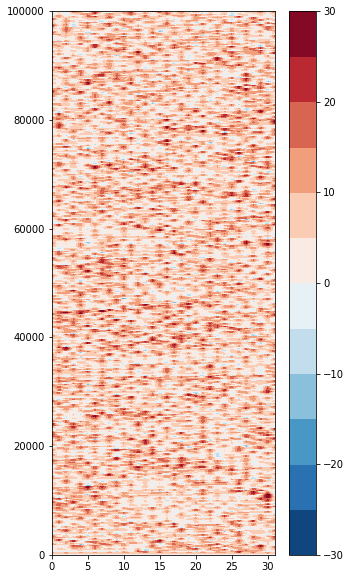

In [9]:
def main():
    K = 32
    J = 8
    X = np.zeros(K)
    Y = np.zeros(J * K)
    X = np.random.random(size=K)
    Y = np.random.random(size=J * K)
    X[0] = 1
    Y[0] = 1
    h = 1
    F = 30
    b = 10
    c = 10
    time_step = 0.001
    num_steps = 100000
    X_out, Y_out = run_lorenz96_truth(X, Y, h, F, b, c, time_step, num_steps)
    print(X_out.max(), X_out.min())
    plt.figure(figsize=(5, 10))
    plt.contourf(X_out, np.linspace(-F, F, 13), cmap="RdBu_r")
    plt.colorbar()
    plt.show()
    return 

        
if __name__ == "__main__":
    main()